# Лабораторная работа №5. Уравнение переноса (гладкая постановка задачи).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

## 1. Постановка задачи

Рассматривается одномерное линейное уравнение переноса (или адвекции):

$$
\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0
$$

где:
*   `u(x, t)` – искомая функция, зависящая от пространственной координаты `x` и времени `t`.
*   `a` – постоянная скорость переноса.

Задача решается на следующей расчетной области:
*   Пространственная координата: `x ∈ [0, L]`
*   Время: `t ∈ [0, T_final]`

Для однозначного решения задачи необходимо задать начальные и граничные условия.

### 1.1. Гладкая задача (Smooth Problem)

*   **Параметры области и скорости:**
    *   `L = L_smooth = 2π` (длина пространственной области)
    *   `T_final = T_final_smooth = 2π` (конечное время моделирования)
    *   `a = a_smooth = 1.0` (скорость переноса)

*   **Начальное условие (при t=0):**
    $$
    u(x, 0) = u_0(x) = \sin(k x)
    $$
    где $k = \frac{2π}{L}$. В данном случае, $k = \frac{2π}{2π} = 1$, поэтому `u_0(x) = sin(x)`.

*   **Граничное условие (при x=0):**
    $$
    u(0, t) = g(t) = -\sin(k a t)
    $$
    Для `k=1, a=1`, получаем `g(t) = -sin(t)`. Это условие согласуется с аналитическим решением, если оно имеет вид `sin(k(x-at))`.

In [2]:
# --- Parameters of smooth problem ---
L_smooth = 2 * np.pi  # max x
T_final_smooth = 2 * np.pi # max t
a_smooth = 1.0          # speed

# --- Initial and border conditions ---
def u0_func_smooth(x, L_domain=L_smooth):
    k = 2 * np.pi / L_domain
    return np.sin(k * x)

def g_func_smooth(t, L_domain=L_smooth, a_coeff=a_smooth):
    k = 2 * np.pi / L_domain
    return -np.sin(k * a_coeff * t)


## 2. Аналитическое решение

Для уравнения переноса $\frac{∂u}{∂t} + a \cdot \frac{∂u}{∂x} = 0$ с начальным условием `u(x, 0) = u_0(x)`, общее решение имеет вид:

$$
u(x, t) = u_0(x - at)
$$

Для конкретной задачи, где `u_0(x) = sin(kx)`, аналитическое решение будет:

$$
u(x, t) = \sin(k(x - at))
$$
Это решение используется в качестве эталона для оценки точности численных методов.

In [3]:
# --- 1. Analytical solution ---
def analytical_solution_smooth(x, t, L_domain=L_smooth, a_coeff=a_smooth):
    k = 2 * np.pi / L_domain
    if isinstance(x, (int, float)) and isinstance(t, (int, float)):
        return np.sin(k * (x - a_coeff * t))
    else:
        return np.sin(k * (x - a_coeff * t))


## 3. Численные методы решения

Для численного решения вводим расчетную сетку. Пространственная область `[0, L]` разбивается на `Nx` интервалов длиной $Δx = \frac{L}{Nx}$. Временной интервал `[0, T_final]` разбивается на `Nt` шагов длительностью $Δt = \frac{T_{final}}{Nt}$. Значение функции `u(x_i, t_n)` в узле сетки `(x_i = iΔx, t_n = nΔt)` обозначается как $u_i^n$.

Ключевым безразмерным параметром является число Куранта-Фридрихса-Леви (CFL), или просто число Куранта:

$$
\sigma = \frac{a \Delta t}{\Delta x}
$$

В программе реализованы три явные разностные схемы:

### 3.1. Схема "против потока" (Upwind Scheme)

Эта схема является условно устойчивой (при `|σ| ≤ 1`) и имеет первый порядок аппроксимации по времени и пространству ($O(Δt, Δx)$). Выбор шаблона зависит от знака скорости `a`:

*   Если `a > 0` (поток направлен вправо):
    $$
    \frac{u_i^{n+1} - u_i^n}{\Delta t} + a \frac{u_i^n - u_i-1^n}{\Delta x} = 0
    $$
    $$
    u_i^{n+1} = u_i^n - \sigma (u_i^n - u_i-1^n)
    $$

*   Если `a < 0` (поток направлен влево):
    $$
    \frac{u_i^{n+1} - u_i^n}{\Delta t} + a \frac{u_i+1^n - u_i^n}{\Delta x} = 0
    $$
    $$
    u_i^{n+1} = u_i^n - \sigma (u_i+1^n - u_i^n)
    $$

*   Если `a = 0`:
    $$
    u_i^{n+1} = u_i^n
    $$

### 3.2. Схема Лакса-Фридрихса (Lax-Friedrichs Scheme)

Эта схема также условно устойчива (при `|σ| ≤ 1`) и имеет первый порядок аппроксимации ($O(Δt, Δx)$), но часто записывается как $O(Δt, Δx^2, (Δt)^2/Δx)$.

$$
\frac{u_i^{n+1} - \frac{1}{2}(u_{i+1}^n + u_{i-1}^n)}{\Delta t} + a \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x} = 0
$$
$$
u_i^{n+1} = \frac{1}{2}(u_{i+1}^n + u_{i-1}^n) - \frac{\sigma}{2} (u_{i+1}^n - u_{i-1}^n)
$$

### 3.3. Схема Лакса-Вендроффа (Lax-Wendroff Scheme)

Эта схема условно устойчива (при `|σ| ≤ 1`) и имеет второй порядок аппроксимации по времени и пространству ($O(Δt^2, Δx^2)$).

$$
u_i^{n+1} = u_i^n - \frac{\sigma}{2} (u_{i+1}^n - u_{i-1}^n) + \frac{\sigma^2}{2} (u_{i+1}^n - 2u_i^n + u_{i-1}^n)
$$

### 3.4. Обработка граничных условий

*   **Левая граница (x=0):** $u_0^{n+1}$ задается аналитически функцией $g(t_{n+1})$.
*   **Правая граница (x=L):** Для `a > 0` (отток из области), в коде используется аппроксимация первого порядка "против потока" (схема Upwind). Для `a < 0` (приток в область), используется экстраполяция нулевого порядка ($u_{Nx}^{n+1} = u_{Nx}^n$). Для `a=0` также $u_{Nx}^{n+1} = u_{Nx}^n$.


In [4]:
# --- 2. Numerical solution ---
def solve_scheme(Nx, Nt_or_CFL, L_param, T_param, a_param, u0_f, g_f, scheme_type='upwind', use_cfl_for_dt=True):
    """
    Universal solver:
    Args:
        Nx (int): number of x-intervals
        Nt_or_CFL (float or int): number of t-intervals/Courant number (CFL)
        L_param, T_param, a_param: parameters of the problem
        u0_f, g_f: funcs of initial and border conditions
        scheme_type (str): 'upwind'/'lax_friedrichs'/'lax_wendroff'
        use_cfl_for_dt (bool): True - CFL, False - Nt
    """
    dx = L_param / Nx
    
    cfl_to_check = -1.0

    if use_cfl_for_dt:
        cfl_number = Nt_or_CFL
        if abs(a_param) < 1e-15 : 
             dt = T_param / 100 
             # print(f"Info: a_param is ~0 ({a_param}), using arbitrary dt for CFL mode.")
             cfl_to_check = 0 
        elif abs(dx) < 1e-15: 
             dt = T_param / 100
             # print(f"Info: dx is ~0 ({dx}), using arbitrary dt for CFL mode.")
             cfl_to_check = float('inf')
        else:
            dt = cfl_number * dx / abs(a_param) 
        
        if dt < 1e-15: 
            # print(f"Info: Calculated dt is too small ({dt}), setting Nt_actual to a large number or T_param/eps.")
            Nt_actual = int(T_param / (1e-9))
            if Nt_actual == 0: Nt_actual = 1
        else:
            Nt_actual = int(T_param / dt)
        
        if Nt_actual == 0: Nt_actual = 1
        dt = T_param / Nt_actual
        if abs(dx) > 1e-15 and abs(a_param) > 1e-15:
            cfl_to_check = abs(a_param) * dt / dx
        elif abs(dx) < 1e-15 and abs(a_param) > 1e-15 :
            cfl_to_check = float('inf')
        else:
            cfl_to_check = 0

    else: # use_cfl_for_dt is False
        Nt_actual = int(Nt_or_CFL)
        if Nt_actual == 0: 
            print("Warning: Nt specified as 0, setting to 1.")
            Nt_actual = 1
        dt = T_param / Nt_actual
        
        if abs(dx) < 1e-15:
            cfl_to_check = float('inf') if abs(a_param) > 1e-15 else 0
        elif abs(a_param) < 1e-15:
            cfl_to_check = 0
        else:
            cfl_to_check = abs(a_param) * dt / dx
        print(f"  Info (Nx, Nt specified): Nx={Nx}, Nt={Nt_actual}. Calculated CFL = {cfl_to_check:.4f}")

    x_grid = np.linspace(0, L_param, Nx + 1)
    t_grid = np.linspace(0, T_param, Nt_actual + 1)
    
    u = np.zeros((Nt_actual + 1, Nx + 1))
    u[0, :] = u0_f(x_grid, L_domain=L_param)

    sigma = a_param * dt / dx 

    if cfl_to_check > 1.0 + 1e-9 : 
         print(f"  Warning: Scheme {scheme_type}, Calculated CFL = {cfl_to_check:.4f} > 1. May be unstable.")

    for n in range(Nt_actual):
        u[n+1, 0] = g_f(t_grid[n+1], L_domain=L_param, a_coeff=a_param)
        
        if scheme_type == 'upwind':
            for i in range(1, Nx + 1): # cycle for processing right border
                if a_param > 0:
                    u[n+1, i] = u[n, i] - sigma * (u[n, i] - u[n, i-1])
                elif a_param < 0:
                    if i < Nx:
                        u[n+1, i] = u[n, i] - sigma * (u[n, i+1] - u[n, i])
                    else:
                        u[n+1, i] = u[n,i] 
                else:
                    u[n+1, i] = u[n, i]

        elif scheme_type == 'lax_friedrichs':
            for i in range(1, Nx):
                u[n+1, i] = 0.5 * (u[n, i+1] + u[n, i-1]) - \
                            0.5 * sigma * (u[n, i+1] - u[n, i-1])
            # Using upwind on borders
            if Nx > 0:
                if a_param > 0:
                    u[n+1, Nx] = u[n, Nx] - sigma * (u[n, Nx] - u[n, Nx-1])
                elif a_param < 0:
                     u[n+1, Nx] = u[n, Nx]
                else:
                    u[n+1, Nx] = u[n, Nx]

        elif scheme_type == 'lax_wendroff':
            sigma2 = sigma**2
            # Internal points
            for i in range(1, Nx): # Loop up to Nx-1
                u[n+1, i] = u[n, i] - \
                            0.5 * sigma * (u[n, i+1] - u[n, i-1]) + \
                            0.5 * sigma2 * (u[n, i+1] - 2*u[n, i] + u[n, i-1])
            
            # Right boundary u[n+1, Nx] with 2nd order one-sided scheme if a_param > 0
            if Nx > 0:
                if a_param > 0:
                    if Nx >= 2: # Need at least u_N, u_{N-1}, u_{N-2}
                        u_Nx_n = u[n, Nx]
                        u_Nxm1_n = u[n, Nx-1]
                        u_Nxm2_n = u[n, Nx-2]
                        term1_ux = 3*u_Nx_n - 4*u_Nxm1_n + u_Nxm2_n
                        term2_uxx = u_Nx_n - 2*u_Nxm1_n + u_Nxm2_n
                        u[n+1, Nx] = u_Nx_n - 0.5 * sigma * term1_ux + 0.5 * sigma2 * term2_uxx
                    elif Nx == 1: # Only u_0 and u_1. Fallback to 1st order Upwind for u_1.
                        u[n+1, Nx] = u[n, Nx] - sigma * (u[n, Nx] - u[n, Nx-1]) # u[n,Nx-1] is u[n,0]
                elif a_param < 0: # Inflow from right
                     u[n+1, Nx] = u[n,Nx] # Simple extrapolation
                else: # a_param == 0
                    u[n+1, Nx] = u[n, Nx]
    return u, x_grid, t_grid

In [5]:
# --- 3. Drawing heatmaps ---
def plot_heatmap(u_data, x_plot_grid, t_plot_grid, title, ax, vmin=-1.1, vmax=1.1):
    X, T = np.meshgrid(x_plot_grid, t_plot_grid)
    pcm = ax.pcolormesh(X, T, u_data, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title(title)
    return pcm

Nx_vis = 600  # Number of x-ranges
Nt_vis = 1000 # Number of t-ranges

print(f"Parameters of visualization: Nx = {Nx_vis}, Nt = {Nt_vis}, L = {L_smooth:.2f}, T_final = {T_final_smooth:.2f}, a = {a_smooth}")

Parameters of visualization: Nx = 600, Nt = 1000, L = 6.28, T_final = 6.28, a = 1.0


In [6]:
# Solution for upwind
print("\nCalculations with scheme 'Upwind':")
U_upwind_s, x_up_s, t_up_s = solve_scheme(
    Nx_vis, Nt_vis, L_smooth, T_final_smooth, a_smooth, 
    u0_func_smooth, g_func_smooth, scheme_type='upwind', use_cfl_for_dt=False
)

# Solution for Lax-Friedrichs
print("\nCalculations with scheme 'Lax-Friedrichs':")
U_laxfr_s, x_lf_s, t_lf_s = solve_scheme(
    Nx_vis, Nt_vis, L_smooth, T_final_smooth, a_smooth, 
    u0_func_smooth, g_func_smooth, scheme_type='lax_friedrichs', use_cfl_for_dt=False
)

# Solution for Lax-Wendorff
print("\nCalculations with scheme 'Lax-Wendorff':")
U_laxwen_s, x_lw_s, t_lw_s = solve_scheme(
    Nx_vis, Nt_vis, L_smooth, T_final_smooth, a_smooth, 
    u0_func_smooth, g_func_smooth, scheme_type='lax_wendroff', use_cfl_for_dt=False
)

# Analytical solution for comparation
X_an_s, T_an_s = np.meshgrid(x_up_s, t_up_s)
U_analytical_grid_s = analytical_solution_smooth(X_an_s, T_an_s, L_domain=L_smooth, a_coeff=a_smooth)


Calculations with scheme 'Upwind':
  Info (Nx, Nt specified): Nx=600, Nt=1000. Calculated CFL = 0.6000

Calculations with scheme 'Lax-Friedrichs':
  Info (Nx, Nt specified): Nx=600, Nt=1000. Calculated CFL = 0.6000

Calculations with scheme 'Lax-Wendorff':
  Info (Nx, Nt specified): Nx=600, Nt=1000. Calculated CFL = 0.6000


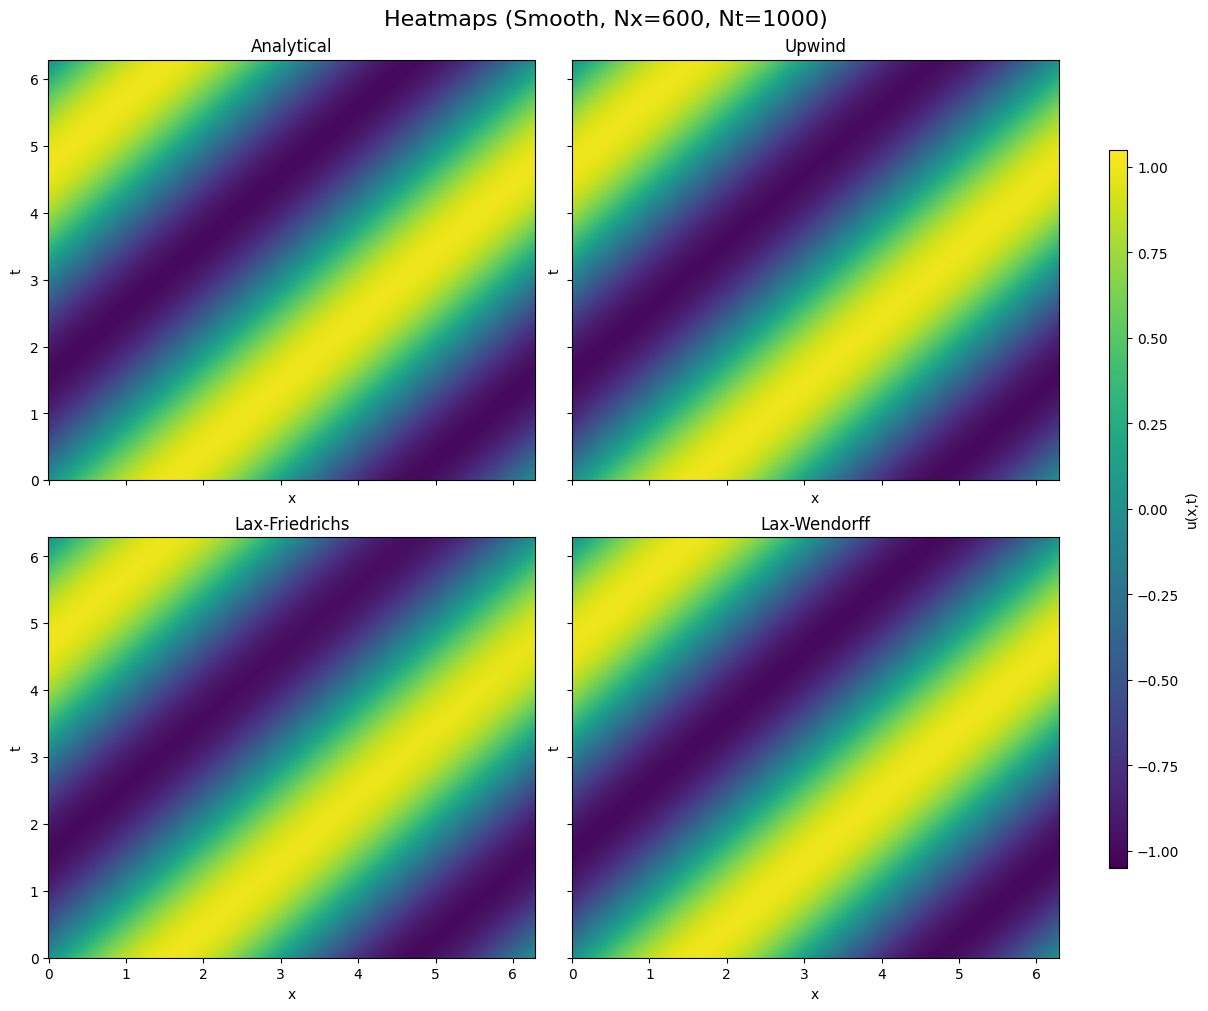

In [7]:
# Creating heatmaps
fig_s, axes_s = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, constrained_layout=True)
title_suffix = f'(Smooth, Nx={Nx_vis}, Nt={Nt_vis})'
fig_s.suptitle(f'Heatmaps {title_suffix}', fontsize=16)
vmin_s, vmax_s = -1.05, 1.05

pcm_s = plot_heatmap(U_analytical_grid_s, x_up_s, t_up_s, f'Analytical', axes_s[0, 0], vmin=vmin_s, vmax=vmax_s)
plot_heatmap(U_upwind_s, x_up_s, t_up_s, f'Upwind', axes_s[0, 1], vmin=vmin_s, vmax=vmax_s)
plot_heatmap(U_laxfr_s, x_lf_s, t_lf_s, f'Lax-Friedrichs', axes_s[1, 0], vmin=vmin_s, vmax=vmax_s)
plot_heatmap(U_laxwen_s, x_lw_s, t_lw_s, f'Lax-Wendorff', axes_s[1, 1], vmin=vmin_s, vmax=vmax_s)

fig_s.colorbar(pcm_s, ax=axes_s.ravel().tolist(), orientation='vertical', label='u(x,t)', aspect=40, shrink=0.8)
plt.show()

## 4. Анализ сходимости и аппроксимации

**Аппроксимация** характеризует, насколько хорошо разностная схема приближает исходное дифференциальное уравнение. Порядок аппроксимации определяется по остаточному члену в разложении Тейлора.

**Сходимость** означает, что численное решение стремится к точному (аналитическому) решению при уменьшении шагов сетки (`Δx → 0`, `Δt → 0`). Для линейных задач, согласно теореме Лакса, устойчивость и аппроксимация являются необходимыми и достаточными условиями сходимости. Порядок сходимости обычно совпадает с порядком аппроксимации.

В лабораторной проводится анализ аппроксимации путем:
1.  Вычисления численных решений на последовательности сеток с уменьшающимся шагом `Δx` (`Nx = 20, 40, 80, 160`).
2.  Шаг по времени `Δt` выбирается таким образом, чтобы число Куранта `σ` оставалось постоянным (`σ ≈ 0.4`). Это важно для корректного анализа пространственной сходимости.
3.  Для каждой сетки вычисляется ошибка численного решения по сравнению с аналитическим в конечный момент времени `T_final`. В качестве метрики ошибки используется дискретная L2-норма:
    $$
    \text{Error} = \sqrt{\Delta x \sum_{i=0}^{Nx} (u_{\text{num}}(x_i, T_{\text{final}}) - u_{\text{analyt}}(x_i, T_{\text{final}}))^2}
    $$
4.  Строится график зависимости ошибки от `Δx` в логарифмическом масштабе.

**Ожидаемые результаты на графике сходимости:**
*   **Схема "против потока" (Upwind):** Наклон графика должен соответствовать первому порядку сходимости (Error ∝ $Δx$).
*   **Схема Лакса-Фридрихса (Lax-Friedrichs):** Также ожидается первый порядок сходимости (Error ∝ $Δx$).
*   **Схема Лакса-Вендроффа (Lax-Wendroff):** Ожидается второй порядок сходимости (Error ∝ $Δx^2$).

На графике также строятся теоретические линии для первого и второго порядков, чтобы визуально оценить фактический порядок сходимости каждого метода.

In [8]:
# --- 4. Convergence analysis ---
Nx_values_conv = [20, 40, 80, 160] 
Nt_for_Nx = {20: 50, 40: 100, 80: 200, 160: 400}

errors_upwind_conv = []
errors_laxfr_conv = []
errors_laxwen_conv = []
dx_values_conv = []
actual_cfls = {'upwind': [], 'lax_friedrichs': [], 'lax_wendroff': []}


for Nx_curr in Nx_values_conv:
    Nt_curr = Nt_for_Nx.get(Nx_curr, 2*Nx_curr)
    print(f"\nConvergence: calculations for Nx = {Nx_curr}, Nt = {Nt_curr}")
    
    dx = L_smooth / Nx_curr
    dx_values_conv.append(dx)
    
    # --- Upwind ---
    print("  Scheme: upwind")
    U_up_c, x_c, t_c = solve_scheme(
        Nx_curr, Nt_curr, L_smooth, T_final_smooth, a_smooth,
        u0_func_smooth, g_func_smooth, scheme_type='upwind', use_cfl_for_dt=False
    )
    if len(t_c) > 0:
        u_an_c = analytical_solution_smooth(x_c, t_c[-1], L_domain=L_smooth, a_coeff=a_smooth)
        errors_upwind_conv.append(np.sqrt(dx * np.sum((U_up_c[-1, :] - u_an_c)**2)))
    else: errors_upwind_conv.append(np.nan)

    # --- Lax-Friedrichs ---
    print("  Scheme: Lax-Friedrichs")
    U_lf_c, x_c, t_c = solve_scheme(
        Nx_curr, Nt_curr, L_smooth, T_final_smooth, a_smooth,
        u0_func_smooth, g_func_smooth, scheme_type='lax_friedrichs', use_cfl_for_dt=False
    )
    if len(t_c) > 0:
        u_an_c = analytical_solution_smooth(x_c, t_c[-1], L_domain=L_smooth, a_coeff=a_smooth)
        errors_laxfr_conv.append(np.sqrt(dx * np.sum((U_lf_c[-1, :] - u_an_c)**2)))
    else: errors_laxfr_conv.append(np.nan)

    # --- Lax-Wendorff ---
    print("  Scheme: Lax-Wendorff")
    U_lw_c, x_c, t_c = solve_scheme(
        Nx_curr, Nt_curr, L_smooth, T_final_smooth, a_smooth,
        u0_func_smooth, g_func_smooth, scheme_type='lax_wendroff', use_cfl_for_dt=False
    )
    if len(t_c) > 0:
        u_an_c = analytical_solution_smooth(x_c, t_c[-1], L_domain=L_smooth, a_coeff=a_smooth)
        errors_laxwen_conv.append(np.sqrt(dx * np.sum((U_lw_c[-1, :] - u_an_c)**2)))
    else: errors_laxwen_conv.append(np.nan)

    print(f"  Ended for Nx={Nx_curr}. Errors (Up, LF, LW): "
          f"{errors_upwind_conv[-1]:.2e} (CFL ~{abs(a_smooth) * (T_final_smooth/Nt_curr) / dx :.2f}), "
          f"{errors_laxfr_conv[-1]:.2e}, {errors_laxwen_conv[-1]:.2e}")




Convergence: calculations for Nx = 20, Nt = 50
  Scheme: upwind
  Info (Nx, Nt specified): Nx=20, Nt=50. Calculated CFL = 0.4000
  Scheme: Lax-Friedrichs
  Info (Nx, Nt specified): Nx=20, Nt=50. Calculated CFL = 0.4000
  Scheme: Lax-Wendorff
  Info (Nx, Nt specified): Nx=20, Nt=50. Calculated CFL = 0.4000
  Ended for Nx=20. Errors (Up, LF, LW): 4.74e-01 (CFL ~0.40), 1.02e+00, 1.01e-01

Convergence: calculations for Nx = 40, Nt = 100
  Scheme: upwind
  Info (Nx, Nt specified): Nx=40, Nt=100. Calculated CFL = 0.4000
  Scheme: Lax-Friedrichs
  Info (Nx, Nt specified): Nx=40, Nt=100. Calculated CFL = 0.4000
  Scheme: Lax-Wendorff
  Info (Nx, Nt specified): Nx=40, Nt=100. Calculated CFL = 0.4000
  Ended for Nx=40. Errors (Up, LF, LW): 2.64e-01 (CFL ~0.40), 6.94e-01, 2.39e-02

Convergence: calculations for Nx = 80, Nt = 200
  Scheme: upwind
  Info (Nx, Nt specified): Nx=80, Nt=200. Calculated CFL = 0.4000
  Scheme: Lax-Friedrichs
  Info (Nx, Nt specified): Nx=80, Nt=200. Calculated CFL = 0.

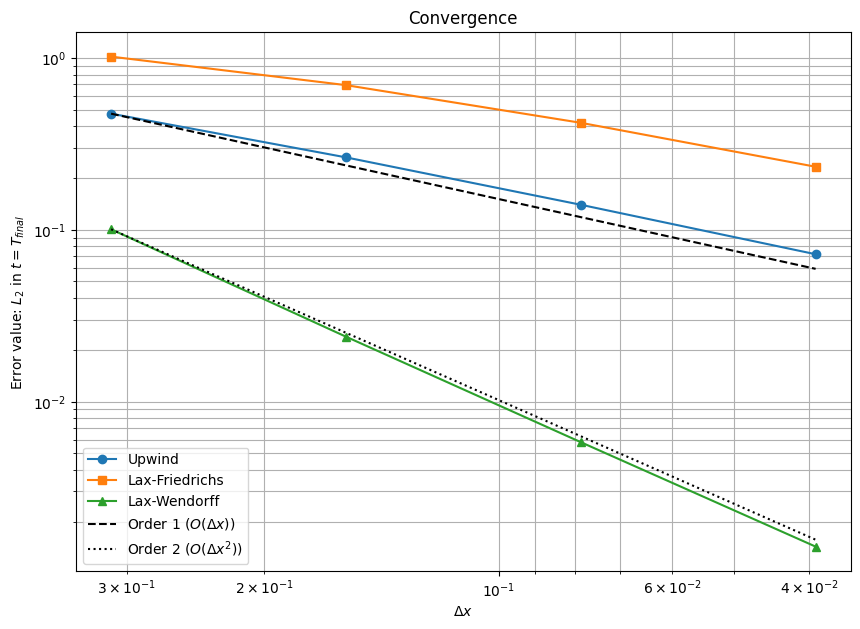

In [9]:
# Creating plot of covergence
plt.figure(figsize=(10, 7))
plt.loglog(dx_values_conv, errors_upwind_conv, 'o-', label='Upwind')
plt.loglog(dx_values_conv, errors_laxfr_conv, 's-', label='Lax-Friedrichs')
plt.loglog(dx_values_conv, errors_laxwen_conv, '^-', label='Lax-Wendorff')

# Theoretical lines
valid_errors_up = [e for e in errors_upwind_conv if not np.isnan(e)]
valid_dx_up = [dx_values_conv[i] for i, e in enumerate(errors_upwind_conv) if not np.isnan(e)]
if valid_errors_up:
    order1_line_s = [valid_errors_up[0] * (dx_val / valid_dx_up[0])**1 for dx_val in valid_dx_up]
    plt.loglog(valid_dx_up, order1_line_s, 'k--', label='Order 1 ($O(\Delta x)$)')

valid_errors_lw = [e for e in errors_laxwen_conv if not np.isnan(e)]
valid_dx_lw = [dx_values_conv[i] for i, e in enumerate(errors_laxwen_conv) if not np.isnan(e)]
if valid_errors_lw:
    order2_line_s = [valid_errors_lw[0] * (dx_val / valid_dx_lw[0])**2 for dx_val in valid_dx_lw]
    plt.loglog(valid_dx_lw, order2_line_s, 'k:', label='Order 2 ($O(\Delta x^2)$)')

plt.xlabel('$\Delta x$')
plt.ylabel('Error value: $L_2$ in $t=T_{final}$')
plt.title('Convergence')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.gca().invert_xaxis()
plt.show()

## Выводы
В данной лабораторной работе мы численно решили `уравнение переноса` (гладкая постановка задачи) при помощи трех схем: `уголок`, `Лакса-Фридрихса (прямоугольник)` и `Лакса-Вендорффа`. При выбранной расчетной сетке тепловые карты решения визуально неотличимы от аналитического решения уравнения. Также мы провели `анализ аппроксимации` численных схем. Для этого, меняя расчетную сетку так, чтобы `число Куранта` было одним и тем же, мы вычисляли `ошибку численного решения` при помощи $L_2$-нормы. Полученные результаты совпали с теоретическими для схем `уголок` и `Лакса-Вендорффа` (`линейный` и `квадратичный` соответственно). Схема же `Лакса-Фридрихса` показала результат `существенно меньший, чем линейный`. Это можно объяснить `высокой численной диффузией` данной схемы, вследствие чего при относительно больших $\Delta x$ линейный порядок аппроксимации, который нам гарантирует теория, не достигается.